In [1]:
!pip install tf_slim matplotlib

  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
import tf_slim as slim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import itertools
import random
%matplotlib inline
np.random.seed(2)

In [5]:
!nvidia-smi

Fri Apr 16 10:57:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    19W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def SRM(imgs):
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    q = [4.0, 12.0, 2.0]
    filter1 = np.asarray(filter1, dtype=float) / 4
    filter2 = np.asarray(filter2, dtype=float) / 12
    filter3 = np.asarray(filter3, dtype=float) / 2
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = tf.Variable(filters, dtype=tf.float32)
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    op = tf.nn.conv2d(input, filters, strides=[1, 1, 1, 1], padding='SAME')

    q = [4.0, 12.0, 2.0]
    filter1 = [[0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 2, -4, 2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1, -2, 1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / q[0]
    filter2 = np.asarray(filter2, dtype=float) / q[1]
    filter3 = np.asarray(filter3, dtype=float) / q[2]
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = filters.flatten()
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    initializer_srm = tf.constant_initializer(filters)
    def truncate_2(x):
        neg = ((x + 2) + abs(x + 2)) / 2 - 2
        return -(-neg+2 + abs(- neg+2)) / 2 + 2
    op2 = slim.conv2d(input, 3, [5, 5], trainable=False, weights_initializer=initializer_srm, activation_fn=None, padding='SAME', stride=1, scope='srm')
    op2 = truncate_2(op2)

    res = np.round(op[0])
    res[res > 2] = 2
    res[res < -2] = -2

    ress = np.array([res], dtype=float)
    ress2 = np.array(op2, dtype=float)
    return ress2

In [26]:
h = 300
w = 300
image_size = (h, w)

# np_arr = lambda img: img.resize(image_size).flatten() / 255.0

def prepare_image(image_path):
    img = Image.open(image_path)
    img = img.resize(image_size)
    img = np.asarray(img)
    return SRM([img])

In [27]:
# img = Image.open('Tp_D_NNN_M_N_pla10121_cha00027_11669.jpg')
# # img = np.asarray(img)
# img = img.resize(image_size)
# img = np.asarray(img) /255.0
# img.shape

In [28]:
# # To List 5 files in your accessible bucket
# # fs.ls('{}/'.format(filenames[1]))[:5]

# # open it directly
# with fs.open('{}/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg'.format(filenames[1])) as f:
#     cat = prepare_image(f)
#     plt.imshow(cat[0])
#     # plt.show()
#     plt.axis('off')
#     plt.savefig("srm.png", bbox_inches='tight', pad_inches=0)

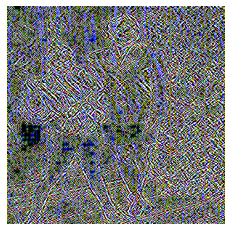

In [29]:
cat = prepare_image('forgery/data/Tp/Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg')
plt.imshow(cat[0])
# plt.show()
plt.axis('off')
plt.savefig("srm.png", bbox_inches='tight', pad_inches=0)

In [30]:
X = [] # SRM converted images
Y = [] # 0 for fake, 1 for real

In [32]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [33]:
# aws s3 cp --recursive s3://sagemaker-studio-xlfqlis2u1/CASIA2/ data

In [34]:
#place authentic
Au_path = 'forgery/data/Au'
prepare_data(Au_path, 1)
random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images


/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
7329 7329


In [35]:
#place tampered
Tp_path = 'forgery/data/Tp'
prepare_data(Tp_path, 0)
print(len(X), len(Y))

Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
9393 9393


In [36]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, h, w, 3)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

X = X.reshape(-1,1,1,1)

In [43]:
input = Input(shape=(h, w, 3))
x = Conv2D(32, 5, padding='valid', activation='relu')(input)
# x = BatchNormalization()(x)
x = Conv2D(32, 5, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.25)(x)
# x = Conv2D(64, 5, padding='valid', activation='relu')(op)
# x = Conv2D(64, 5, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 32)      2432      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 292, 292, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 146, 146, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 146, 146, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 682112)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [38]:
# input = Input(shape=(h,w,3), name='srm')
# x = Conv2D(64, 3, activation='relu', padding='same')(input)
# x = BatchNormalization()(x)
# x = Conv2D(64, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(padding='same')(x)
# x = BatchNormalization()(x)

# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(padding='same')(x)
# x = BatchNormalization()(x)

# x = Conv2D(256, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(padding='same')(x)
# x = BatchNormalization()(x)

# x = Conv2D(512, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, 3, activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, 3, activation='relu', padding='same')(x)
# x = MaxPool2D(padding='same')(x)
# x = BatchNormalization()(x)

# # x = Conv2D(512, 3, activation='relu', padding='same')(x)
# # x = Conv2D(512, 3, activation='relu', padding='same')(x)
# # x = Conv2D(512, 3, activation='relu', padding='same')(x)

# x = Flatten()(x)
# x = BatchNormalization()(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)

# output = Dense(2, activation='softmax')(x)

# model = tf.keras.Model(inputs=[input], outputs=[output])
# model.summary()

In [44]:
epochs = 100
batch_size = 32
init_lr = 1e-3
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=2, verbose=0, mode='auto')

checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 3.3452 - accuracy: 0.7800WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 56s 239ms/step - loss: 3.3452 - accuracy: 0.7800 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 42s 177ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 171ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 169ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 168ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 168ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 169ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 40s 168ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 9/100
235/235 [==============================] - ETA: 0s - loss: 3.3577 - accuracy: 0.7811WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


235/235 [==============================] - 39s 168ms/step - loss: 3.3577 - accuracy: 0.7811 - val_loss: 3.4200 - val_accuracy: 0.7770
Epoch 10/100
 86/235 [=========>....................] - ETA: 23s - loss: 3.5612 - accuracy: 0.7678

KeyboardInterrupt: 

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# def SRM(imgs):
#     c=np.zeros((3,5,5))
#     c[0]=[[-1,2,-2,2,-1],[2,-6,8,-6,2],[-2,8,-12,8,-2],[2,-6,8,-6,2],[-1,2,-2,2,-1]]
#     c[0]=c[0]/12

#     c[1][1][1]=-1
#     c[1][1][2]=2
#     c[1][1][3]=-1
#     c[1][2][1]=2
#     c[1][2][2]=-4
#     c[1][2][3]=2
#     c[1][3][1]=-1
#     c[1][3][2]=2
#     c[1][3][3]=-1
#     c[1]=c[1]/4

#     c[2][1][2]=1
#     c[2][2][2]=-2
#     c[2][3][2]=1
#     c[2]=c[2]/2   

#     Wcnn=np.zeros((5,5,3,3))
#     for i in range(3):
#         Wcnn[:,:,0,i]=c[i]
#         Wcnn[:,:,1,i]=c[i]
#         Wcnn[:,:,2,i]=c[i]

#     imgs = np.array(imgs, dtype=float)
#     input = tf.Variable(imgs, dtype=tf.float32)

#     conv = tf.nn.conv2d(input, Wcnn, [1, 1, 1, 1], padding='SAME',name='srm')
#     res = np.array(conv, dtype=float)
#     return res